# Este script sirve para preprocesar el dataset, se divide en 80% de training y 20% de test.
# Se carga el tokenizador con BERT
# Se convierten los datos tokenizados a tensores de PyTorch

In [2]:
# Bibliotecas estándar y de entorno
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Transformers (HuggingFace)
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim  # Usar AdamW desde torch
# Barra de progreso
from tqdm import tqdm
# Validación y métricas
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

# Crear la carpeta para almacenar los archivos del modelo
output_dir = "Modelo_BERT"
os.makedirs(output_dir, exist_ok=True)

# Cargar el dataset consolidado desde la carpeta donde se guardó previamente
file_path = "Clasificacion_Manual_Dataset_Etiquetado/Dataset_Emociones_Completo.csv"
print(f"Cargando dataset desde: {file_path}")
df = pd.read_csv(file_path, encoding='utf-8')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas")

# Codificar etiquetas de emociones a valores numéricos para que el modelo pueda interpretarlas
print("Codificando etiquetas de emociones...")
emocion_labels = {label: idx for idx, label in enumerate(df["Emocion"].unique())}  # Asigna un número a cada emoción única
df["Emocion"] = df["Emocion"].map(emocion_labels)  # Reemplaza los nombres de emociones por su número correspondiente
print(f"Etiquetas codificadas: {emocion_labels}")

# Dividir el dataset en conjunto de entrenamiento (80%) y prueba (20%)
print("Dividiendo el dataset en entrenamiento y prueba...")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Texto_Procesado"].tolist(),  # Se toma la columna con los textos preprocesados
    df["Emocion"].tolist(),  # Se toma la columna con las emociones codificadas
    test_size=0.2,  # El 20% de los datos se usará para la evaluación
    random_state=42,  # Se fija una semilla para reproducibilidad
    stratify=df["Emocion"]  # Se asegura que la distribución de clases sea balanceada en ambos conjuntos
)
print(f"Conjunto de entrenamiento: {len(train_texts)} muestras, Conjunto de prueba: {len(test_texts)} muestras")

# Guardar los datasets en archivos CSV
train_df = pd.DataFrame({"Texto_Procesado": train_texts, "Emocion": train_labels})
test_df = pd.DataFrame({"Texto_Procesado": test_texts, "Emocion": test_labels})
train_path = os.path.join(output_dir, "Train_Dataset.csv")
test_path = os.path.join(output_dir, "Test_Dataset.csv")

train_df.to_csv(train_path, index=False, encoding='utf-8')
test_df.to_csv(test_path, index=False, encoding='utf-8')

print(f"Train dataset guardado en: {train_path}")
print(f"Test dataset guardado en: {test_path}")

# Cargar el tokenizador de BERT
MODEL_NAME = "bert-base-multilingual-cased"  # Se puede cambiar dependiendo del idioma del dataset
print(f"Cargando tokenizador: {MODEL_NAME}")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Tokenizar los textos para convertirlos en secuencias numéricas que BERT pueda interpretar
print("Tokenizando textos...")
train_encodings = tokenizer(
    train_texts, truncation=True, padding=True, max_length=128  # Se establece un máximo de 128 tokens por texto
)
test_encodings = tokenizer(
    test_texts, truncation=True, padding=True, max_length=128  # Se realiza el mismo procesamiento para el conjunto de prueba
)
print("Tokenización completada.")

# Convertir los datos tokenizados a tensores de PyTorch
print("Convirtiendo datos a tensores de PyTorch...")
train_inputs = torch.tensor(train_encodings["input_ids"])  # IDs de los tokens
train_masks = torch.tensor(train_encodings["attention_mask"])  # Máscara de atención (1 para tokens válidos, 0 para padding)
train_labels = torch.tensor(train_labels)  # Etiquetas de las emociones

test_inputs = torch.tensor(test_encodings["input_ids"])  # IDs de los tokens en el conjunto de prueba
test_masks = torch.tensor(test_encodings["attention_mask"])  # Máscara de atención para el conjunto de prueba
test_labels = torch.tensor(test_labels)  # Etiquetas del conjunto de prueba
print("Conversión a tensores completada.")

# Crear conjuntos de datos para PyTorch con los tensores generados
print("Creando TensorDatasets...")
train_data = TensorDataset(train_inputs, train_masks, train_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
print("TensorDatasets creados exitosamente.")

# Definir el tamaño de lote (batch size) para el entrenamiento y la evaluación
BATCH_SIZE = 16  # Ajustable según la capacidad de memoria de la GPU
print(f"Configurando DataLoaders con batch size de {BATCH_SIZE}...")

# Crear DataLoaders para manejar los datos en lotes y facilitar el entrenamiento
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)  # Se barajan los datos en cada época
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)  # No se barajan los datos de prueba
print("DataLoaders creados correctamente.")

print("Preprocesamiento completado. Datos listos para entrenamiento.")

/Users/luisyael_ms/Documents/Modelos_Colab_Emociones/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargando dataset desde: Clasificacion_Manual_Dataset_Etiquetado/Dataset_Emociones_Completo.csv
Dataset cargado con 2880 filas y 6 columnas
Codificando etiquetas de emociones...
Etiquetas codificadas: {'Felicidad': 0, 'Tristeza': 1, 'Estrés': 2, 'Preocupación': 3, 'Miedo': 4, 'Ira': 5}
Dividiendo el dataset en entrenamiento y prueba...
Conjunto de entrenamiento: 2304 muestras, Conjunto de prueba: 576 muestras
Train dataset guardado en: Modelo_BERT/Train_Dataset.csv
Test dataset guardado en: Modelo_BERT/Test_Dataset.csv
Cargando tokenizador: bert-base-multilingual-cased
Tokenizando textos...
Tokenización completada.
Convirtiendo datos a tensores de PyTorch...
Conversión a tensores completada.
Creando TensorDatasets...
TensorDatasets creados exitosamente.
Configurando DataLoaders con batch size de 16...
DataLoaders creados correctamente.
Preprocesamiento completado. Datos listos para entrenamiento.


# En esta fase se presenta el Script para el entrenamiento del modelo BERT

In [3]:
#Script para generar el entrenamiento del modelo usando BERT

# Codificar etiquetas de emociones a valores numéricos si no están definidas
emocion_labels = {label: idx for idx, label in enumerate(df["Emocion"].unique())}

# Verificar si hay GPU disponible para acelerar el entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Cargar el modelo BERT preentrenado con una capa de clasificación ajustada
NUM_LABELS = len(emocion_labels)  # Número de clases en la clasificación
MODEL_NAME = "bert-base-multilingual-cased"

print("Cargando modelo BERT preentrenado...")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)  # Enviar el modelo a GPU si está disponible

# Cargar el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Definir la función de pérdida y el optimizador
loss_function = nn.CrossEntropyLoss()  # Función de pérdida adecuada para clasificación multiclase
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)  # Optimizador desde PyTorch

# Cargar los datasets desde los archivos CSV
print("Cargando datasets desde archivos CSV...")
train_dataset_path = os.path.join(output_dir, "Train_Dataset.csv")
test_dataset_path = os.path.join(output_dir, "Test_Dataset.csv")
train_df = pd.read_csv(train_dataset_path, encoding='utf-8')
test_df = pd.read_csv(test_dataset_path, encoding='utf-8')
print(f"Datos de entrenamiento: {len(train_df)}, Datos de prueba: {len(test_df)}")

# Tokenizar los textos y convertirlos en tensores
def convert_to_tensor_dataset(df):
    encodings = tokenizer(
        df['Texto_Procesado'].tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = torch.tensor(df['Emocion'].values)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

train_data = convert_to_tensor_dataset(train_df)
test_data = convert_to_tensor_dataset(test_df)

# Crear DataLoaders
BATCH_SIZE = 16
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Número de épocas para el entrenamiento (ajustable según rendimiento)
EPOCHS = 5

# Listas para almacenar métricas de entrenamiento y evaluación
epochs_list = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Función de entrenamiento
def train_model(model, train_dataloader):
    model.train()  # Poner el modelo en modo entrenamiento
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for batch in tqdm(train_dataloader, desc="Entrenando", unit="batch", leave=False):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]  # Mover datos a GPU si está disponible
        optimizer.zero_grad()  # Resetear gradientes
        
        # Realizar la predicción
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_function(outputs.logits, labels)  # Calcular la pérdida
        total_loss += loss.item()
        
        # Backpropagation y optimización
        loss.backward()
        optimizer.step()
        
        # Calcular exactitud de predicciones
        preds = torch.argmax(outputs.logits, dim=1)  # Obtener la clase con mayor probabilidad
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
    
    avg_loss = total_loss / len(train_dataloader)  # Promedio de pérdida por batch
    accuracy = correct_predictions / total_samples  # Exactitud del modelo
    return avg_loss, accuracy

# Función de evaluación (sin actualización de gradientes)
def evaluate_model(model, test_dataloader):
    model.eval()  # Poner el modelo en modo evaluación
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Desactivar el cálculo de gradientes para ahorrar memoria y acelerar la evaluación
        for batch in tqdm(test_dataloader, desc="Evaluando", unit="batch", leave=False):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_function(outputs.logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)  # Obtener la clase predicha
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
    
    avg_loss = total_loss / len(test_dataloader)  # Promedio de pérdida en la evaluación
    accuracy = correct_predictions / total_samples  # Exactitud en el conjunto de prueba
    return avg_loss, accuracy

# Entrenamiento del modelo por el número de épocas definido
for epoch in range(EPOCHS):
    print(f"\n===== Época {epoch+1} de {EPOCHS} =====")
    train_loss, train_acc = train_model(model, train_dataloader)
    test_loss, test_acc = evaluate_model(model, test_dataloader)
    
    print(f"Pérdida en entrenamiento: {train_loss:.4f}, Exactitud: {train_acc:.4f}")
    print(f"Pérdida en prueba: {test_loss:.4f}, Exactitud: {test_acc:.4f}")
    
    # Guardar métricas
    epochs_list.append(epoch+1)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Guardar el modelo entrenado para futuras predicciones
print("Guardando modelo entrenado...")  # Mensaje adicional para depuración
model_save_path = os.path.join(output_dir, "BERT_Emociones_Model.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Modelo guardado en {model_save_path}")

Usando dispositivo: cpu
Cargando modelo BERT preentrenado...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cargando datasets desde archivos CSV...
Datos de entrenamiento: 2304, Datos de prueba: 576

===== Época 1 de 5 =====


Pérdida en entrenamiento: 1.2692, Exactitud: 0.5048
Pérdida en prueba: 0.9537, Exactitud: 0.6493

===== Época 2 de 5 =====


Pérdida en entrenamiento: 0.7360, Exactitud: 0.7209
Pérdida en prueba: 0.7413, Exactitud: 0.7083

===== Época 3 de 5 =====


Pérdida en entrenamiento: 0.5088, Exactitud: 0.8134
Pérdida en prueba: 0.7329, Exactitud: 0.7361

===== Época 4 de 5 =====


Pérdida en entrenamiento: 0.3338, Exactitud: 0.8841
Pérdida en prueba: 0.8628, Exactitud: 0.7135

===== Época 5 de 5 =====


Pérdida en entrenamiento: 0.2728, Exactitud: 0.9041
Pérdida en prueba: 0.8285, Exactitud: 0.7361
Guardando modelo entrenado...
Modelo guardado en Modelo_BERT/BERT_Emociones_Model.pth


# Script para la fase de evaluación del modelo usando BERT

Cargando modelo BERT preentrenado...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cargando tokenizador...
Cargando modelo entrenado desde Modelo_BERT/BERT_Emociones_Model.pth...
Modelo cargado y listo para predicciones.


Evaluando: 100%|██████████| 36/36 [00:14<00:00,  2.54batch/s]


===== Métricas de Evaluación =====
Exactitud (Accuracy): 0.7361
Precisión (Macro): 0.7320
Recall (Macro): 0.7014
F1-Score (Macro): 0.7078
Área bajo la curva ROC-AUC: 0.9426



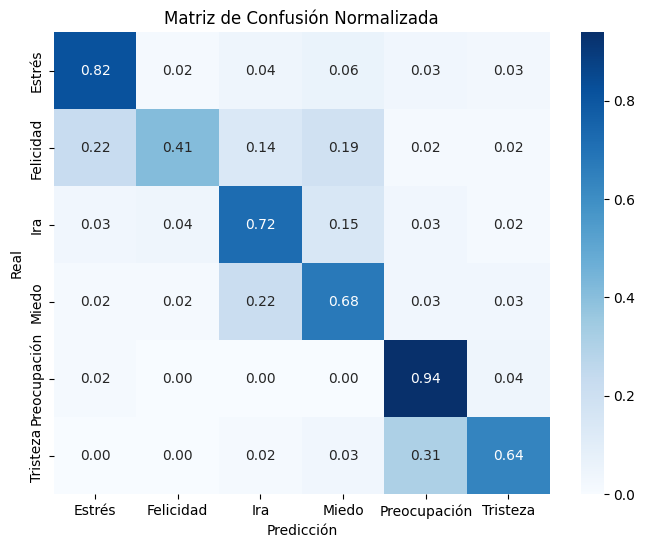

In [13]:
# Cargar el modelo BERT preentrenado con una capa de clasificación ajustada
MODEL_NAME = "bert-base-multilingual-cased"

# Codificación de etiquetas
df = pd.read_csv(file_path, encoding='utf-8')

# Guardar una copia textual original de las emociones
df["Emocion_Textual"] = df["Emocion"]

# Crear codificación
emocion_labels = {etiqueta: idx for idx, etiqueta in enumerate(sorted(df["Emocion_Textual"].unique()))}
reverse_labels = {idx: etiqueta for etiqueta, idx in emocion_labels.items()}

# Codificar emociones
df["Emocion"] = df["Emocion_Textual"].map(emocion_labels)
print("Cargando modelo BERT preentrenado...")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)  # Enviar el modelo a GPU si está disponible

# Cargar el tokenizador de BERT
print("Cargando tokenizador...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Cargar el modelo entrenado previamente
MODEL_PATH = "Modelo_BERT/BERT_Emociones_Model.pth"
print(f"Cargando modelo entrenado desde {MODEL_PATH}...")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()  # Poner el modelo en modo evaluación
print("Modelo cargado y listo para predicciones.")

# Cargar los datasets preprocesados
train_dataset_path = "Modelo_BERT/Train_Dataset.csv"
test_dataset_path = "Modelo_BERT/Test_Dataset.csv"
train_df = pd.read_csv(train_dataset_path, encoding='utf-8')
test_df = pd.read_csv(test_dataset_path, encoding='utf-8')

# Tokenizar los textos y convertirlos en tensores
def convert_to_tensor_dataset(df):
    encodings = tokenizer(
        df['Texto_Procesado'].tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = torch.tensor(df['Emocion'].values)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

train_data = convert_to_tensor_dataset(train_df)
test_data = convert_to_tensor_dataset(test_df)

# Crear DataLoaders
BATCH_SIZE = 16
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Función para predecir la emoción de un texto
def predecir_emocion(texto):
    """
    Tokeniza el texto ingresado, lo pasa por el modelo y devuelve el nombre de la emoción predicha.
    """
    model.eval()  # Asegurar modo evaluación
    inputs = tokenizer(texto, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = int(torch.argmax(logits, dim=1).item())  # Asegurarse que sea int

    # Devolver nombre de la emoción
    emocion_predicha = reverse_labels.get(pred_label, f"Desconocido ({pred_label})")
    return emocion_predicha

# Evaluación del modelo en el conjunto de prueba
def evaluar_modelo(test_dataloader):
    """Evalúa el modelo y calcula métricas de desempeño."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluando", unit="batch"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Calcular métricas de clasificación
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    
    print("\n===== Métricas de Evaluación =====")
    print(f"Exactitud (Accuracy): {accuracy:.4f}")
    print(f"Precisión (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print(f"Área bajo la curva ROC-AUC: {auc_score:.4f}\n")
    
    # Matriz de Confusión Normalizada
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=[reverse_labels[i] for i in range(NUM_LABELS)], yticklabels=[reverse_labels[i] for i in range(NUM_LABELS)])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión Normalizada")
    plt.show()

# Llamar a la evaluación del modelo
evaluar_modelo(test_dataloader)

In [15]:
#Ingresar frase desde teclado para realizar predicción
# Interfaz para ingresar textos y obtener predicciones
import sys

print("\nIngrese una frase para evaluar su emoción. Escriba 'salir' para terminar.\n")
while True:
    print("reverse_labels:", reverse_labels)
    texto_usuario = input("Texto: ")
    sys.stdout.flush()  # Forzar impresión inmediata
    print(texto_usuario)
    if texto_usuario.lower() == "salir":
        print("Saliendo del programa...")
        break
    
    emocion = predecir_emocion(texto_usuario)
    print(f"La emoción predicha es: {emocion}\n")


Ingrese una frase para evaluar su emoción. Escriba 'salir' para terminar.

reverse_labels: {0: 'Estrés', 1: 'Felicidad', 2: 'Ira', 3: 'Miedo', 4: 'Preocupación', 5: 'Tristeza'}
salir
Saliendo del programa...
